# MCMC: SV-GARCH et Particle Filtering

Auteurs: Tom Ciffreo, Rodrigue Rillardon, Axel Marchand

L'objectif de ce notebook python est de:
- Implémenter un filtre à particule appliqué au modèle SV-Garch
- Obtenir une fonction de log-vraissemblance continue en les paramètres
- Tester notre modèle sur des données réelles comme celles de SP-500

# Partie 1 construction du filtre à particule

On importe dans un premier temps les librairies nécessaires

In [3]:
import numpy as np
import scipy.stats
from scipy.stats import uniform
import scipy.optimize
from scipy.optimize import minimize
import math
import sympy
from sympy import DiracDelta
import matplotlib.pyplot as plt
import random

%matplotlib inline

## Création de données

Nous souhaitons dans un premier temps pouvoir générer des données selon le modèle SV-Garch afin de pouvoir tester ensuite notre modèle SV-Garch

In [4]:
def simulate_svgarch(gamma, alpha, beta, phi,  T): #alpha + beta < 1
    if alpha+beta>=1:
        raise NameError("Alpha + Beta must be less than 1")
    
    y = np.zeros(T)
    v = np.zeros(T)
    v[0] = gamma/(1 - alpha - beta)
    for t in range(T-1):
        eps = np.random.normal(0 , 1, size = 1)
        xi = np.random.normal(0,1,size=1)
        zeta = phi*eps+np.sqrt(1-phi**2)*xi
        y[t] = np.sqrt(v[t])*eps
        v[t+1] = gamma + alpha*v[t] + beta*v[t]*(zeta)**2
    return y, v

On représente les séries générées

Text(0.5, 1.0, 'Volatilité latente v')

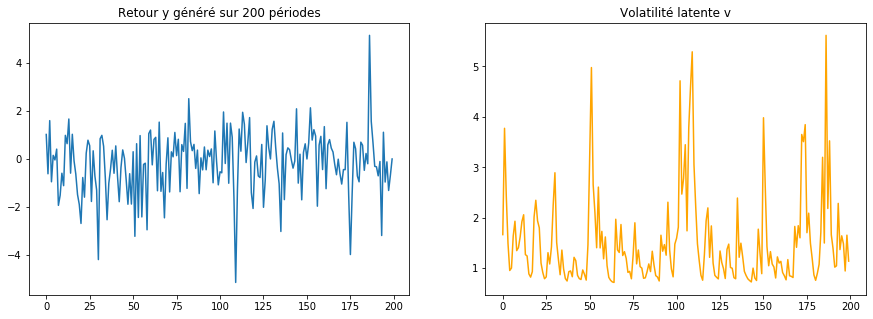

In [5]:
gamma = 0.5
alpha = 0.3
beta = 0.4
phi = 0.01
T = 200
y, v = simulate_svgarch(gamma, alpha, beta, phi, T)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(y)
plt.title("Retour y généré sur 200 périodes")
plt.subplot(122)
plt.plot(v, color="orange")
plt.title("Volatilité latente v")

Nos données sont générées, nous allons maintenant définir notre filtre à particule

## Filtre à particule

In [6]:
class SV_Garch_filtering(object):
    def __init__(self, y, gamma, alpha, beta, phi, M, T, malik=False):
        """
        y: série temporelle à analyser
        gamma, alpha, beta, phi, paramètres initiaux
        M: nombre de i à générer à chaque étape
        T: nombre de période à considérer
        malik: booléen, si true, utilise un sampling continu dans les paramètres
        """
        self.y = y
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.phi = phi
        self.T = T
        self.M = M
        self.V = np.zeros((T, M))
        self.W = np.zeros((T, M))
        self.Lambda = np.zeros((T, M))
        self.t = 0
        self.malik = malik
        self.initial_values()

    def initial_values(self):
        """
        Permet de définir les valeurs initiales v_0
        """
        for i in range(self.M):
            self.V[0, i] = np.random.normal(0, 1, size=1) ** 2
        return self.V[0, :]

    def one_cycle(self):
        """
        Effectue un cycle complet de l'algorithme à particule
        """
        self.next_v()
        self.update_lambda()
        list_new_V = []
        for i in range(self.M):
            if self.malik:
                new_v = self.tirage_malik_pitt_fast()
            else:
                new_v = self.roll_discontinuous()
            list_new_V.append(new_v)
        self.V[self.t + 1, :] = np.array(list_new_V)
        self.t += 1

    def full_cycle(self):
        """
        Effectue l'intégralité du cycle à particule
        """
        for i in range(self.T - 1):
            self.one_cycle()
        return self.V

    def next_v(self):
        """
        Etape 1 du filtre, on génère les nouveaux v
        """
        t = self.t
        assert self.t < self.T
        for i in range(self.M):
            eps = self.y[t] / np.sqrt(self.V[t, i])
            xi = np.random.normal(0, 1, size=1)
            zeta = self.phi * eps + np.sqrt(1 - self.phi ** 2) * xi
            self.V[t + 1, i] = self.gamma + self.alpha * self.V[t, i] + self.beta * self.V[t, i] * (zeta) ** 2

    def update_lambda(self):
        """
        Etape 2 du filtre, on update les lambdas
        """
        t = self.t
        for i in range(self.M):
            self.W[t + 1, i] = ((2 * np.pi * self.V[t + 1, i]) ** (-0.5)) * np.exp(
                -0.5 * (self.y[t + 1] ** 2) / np.sqrt(self.V[t + 1, i]))
        for i in range(self.M):
            self.Lambda[t + 1, i] = self.W[t + 1, i] / sum(self.W[t + 1, :])

    def roll_discontinuous(self):
        """
        Permet de sampler les nouveaux v de l'étape 3 de manière discontinue
        """
        t = self.t
        number = random.uniform(0, np.sum(self.Lambda[t + 1, 1:]))
        current = 0
        for i, bias in enumerate(self.Lambda[t + 1, :]):
            current += bias
            if number <= current:
                return self.V[t + 1, i]

    def roll_malik_pitt(self):
        """
        Permet de sampler les nouveaux v de l'étape 3 de manière continue
        """
        t = self.t
        v_order = (-self.V[t + 1]).argsort()
        v_ordered = self.V[t + 1][v_order[::-1]]
        lbd_ordered = self.Lambda[t + 1][v_order[::-1]]
        trunkated_weights = [(lbd_ordered[i + 1] + lbd_ordered[i]) / 2 for i in range(0, self.M - 1)]

        weight = np.append(trunkated_weights, [lbd_ordered[-1] / 2])
        # print(v_ordered)
        x = np.random.uniform(v_ordered[0], v_ordered[-1])
        v_ordered = np.append(v_ordered, np.inf)
        tirage = self.tirage_sum(x, v_ordered, lbd_ordered)
        return tirage
    
    def tirage_malik_pitt_fast(self):
        u = np.random.uniform(0, 1, size = 1)
        u_sorted = [(j-1)/self.T + u/self.T for j in range(self.T)]
        s = 0
        j = 1
        v_star = [0 for k in range(self.T)]
        for t in range(self.T):
            s += self.Lambda[t,i]
            while (u_sorted[j] <= s) and (j <= self.T):
                r[j] = t
                u_star[j] = (u_sorted[j] - (s - self.Lambda[t,i]))/self.Lambda[t,i]
                j += 1
                if r[j] == 0:
                    v_star[j] = v_ordered[1]
                elif r[j] == self.T:
                    v_star[j] = v_ordered[self.T]
                else:
                    v_star[j] = (v_ordered[r[j]+1] - v_ordered[r[j]])*u_star[j] + v_ordered[r[j]]
        return v_star

    def tirage_uniform(self, x, v_ordered, i):
        """
        Fonction jointe à tirage_sum
        """
        v_ordered = np.append(v_ordered, np.inf)
        if x <= v_ordered[i + 1] and x >= v_ordered[i]:
            return uniform.cdf((x - v_ordered[i]) / (v_ordered[i + 1] - v_ordered[i]))
        else:
            return 0

    def tirage_sum(self, x, v_ordered, lambda_ordered):
        """
        Fonction jointe à malik_pitt
        """
        return sum([lambda_ordered[i] * self.tirage_uniform(x, v_ordered, i) for i in range(self.M)])

## Test du filtre dans le cas discontinu

Nous allons dans un premier temps nous intéresser au filtre à particule dans le cas discontinu.
On calcule la log vraisemblance de la façon suivante

In [7]:
M = 200

def neg_log_likelihood(theta): # theta = [gamma, alpha, beta, phi]
    gamma, alpha, beta, phi = theta[0], theta[1], theta[2], theta[3]
    l = SV_Garch_filtering(y, gamma, alpha, beta, phi, M, T, malik=False)
    m = l.full_cycle()
    t = np.sum(m, axis=0)
    return -np.sum(np.log(t))

On peut ensuite avec le module scipy obtenir le maximum de vraisemblance pour nos paramètres et obtenir les valeurs de theta correspondantes

In [8]:
#calcul du maximum de vraisemblance

theta_0 = np.random.normal(0,1,size=4)
max_vrais = -minimize(neg_log_likelihood, theta_0, method='Nelder-Mead', tol=1e-6).x

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in sqrt


# Partie 2, implémentation des modifications de log vraisemblance continue

Nous avons pu voir lors de l'exemple précédent que notre filtre à particule n'étant pas continu, l'obtention du maximum de vraisemblance est d'autant plus hardu car non dérivable. 

Nous avons donc pu ajouter la variable malik dans le modèle qui permet d'utiliser la méthode de continuité décrite par Malik et Pitt en 2011.

In [9]:
M = 200

def neg_log_likelihood_continuous(theta): # theta = [gamma, alpha, beta, phi]
    gamma, alpha, beta, phi = theta[0], theta[1], theta[2], theta[3]
    l = SV_Garch_filtering(y, gamma, alpha, beta, phi, M, T, malik=True)
    m = l.full_cycle()
    t = np.sum(m, axis=0)
    return -np.sum(np.log(t))

On applique la même fonction de maximisation

In [10]:
theta_0 = np.random.normal(0,1,size=4)
max_vrais = -minimize(neg_log_likelihood_continuous, theta_0, method='Nelder-Mead', tol=1e-6).x

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in sqrt


NameError: name 'i' is not defined

# Partie 3, implémentation sur des données réelles

Nous allons utiliser un asset SP-500 obtenu grâce à Yahoo Finance pour calculer nos paramètres

In [11]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df_sp_500 = pd.read_csv("Data/df_sp_from_2002_close.csv")
df_sp_500.head()

,Unnamed: 0,Close,Close.1,Close.2,Close.3,Close.4,Close.5,Close.6,Close.7,Close.8,...,Adj Close.492,Adj Close.493,Adj Close.494,Adj Close.495,Adj Close.496,Adj Close.497,Adj Close.498,Adj Close.499,Adj Close.500,dates
0,0,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,NaN
1,1,['Agilent Technologies Inc.'],['American Airlines Group Inc.'],['Advance Auto Parts Inc W/I'],['Apple Inc.'],['AbbVie Inc.'],['AmerisourceBergen Corporation'],['ABIOMED Inc.'],['Abbott Laboratories'],['Accenture plc Class A (Ireland)'],...,['Xilinx Inc.'],['Exxon Mobil Corporation'],['DENTSPLY SIRONA Inc.'],['Xerox Corporation'],['Xylem Inc. New'],['Yum! Brands Inc.'],['Zimmer Biomet Holdings Inc.'],['Zions Bancorporation N.A.'],['Zoetis Inc. Class A'],Date
2,2,13.805435999999998,NaN,16.48,1.084286,NaN,14.96,5.1,18.876282,20.02,...,17.634107999999994,22.578367,14.786476,19.982075,NaN,5.771635,35.180012,33.526573,NaN,2002-12-02
3,3,12.918455,NaN,16.32,1.082857,NaN,14.975,5.0,18.934639,19.469998999999998,...,16.811035,22.787304000000002,14.880912,18.935285999999998,NaN,5.646319999999999,36.814114000000004,33.178608000000004,NaN,2002-12-03
4,4,12.238913,NaN,16.75,1.069286,NaN,15.7875,4.92,18.966063000000002,18.139999,...,15.798589000000002,22.702423,14.8989,18.632877,NaN,5.747535,37.095863,33.081505,NaN,2002-12-04


Text(0.5, 1.0, "Evolution de l'asset Agilent Technologies")

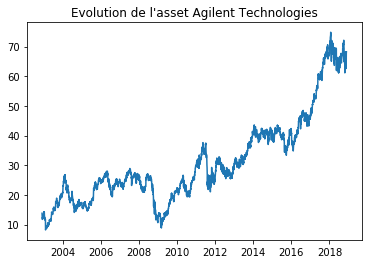

In [12]:
from datetime import date
y = df_sp_500.iloc[2:, 1]
dates = df_sp_500.iloc[2:, -1]
dates = [date.fromisoformat(i) for i in dates]
y = [float(i) for i in y]
plt.plot(dates, y)
plt.title("Evolution de l'asset Agilent Technologies")

In [18]:
M = 200

def neg_log_likelihood(theta): # theta = [gamma, alpha, beta, phi]
    gamma, alpha, beta, phi = theta[0], theta[1], theta[2], theta[3]
    l = SV_Garch_filtering(y, gamma, alpha, beta, phi, M, T, malik=False)
    m = l.full_cycle()
    t = np.sum(m, axis=0)
    return -np.sum(np.log(t))

In [ ]:
theta_0 = np.random.normal(0,1,size=4)
max_vrais = -minimize(neg_log_likelihood, theta_0, method='Powell', tol=1e-6).x

In [ ]:
print(max_vrais)